In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths
import numpy as np

from openpathsampling.analysis.tis_analysis import TISTransition
from openpathsampling.analysis.tis_analysis import sampleset_sample_generator

storage = paths.storage.AnalysisStorage("_toy_retis.nc")

In [2]:
retis = storage.transitions.load(0)
retis.hist_args['pathlength'] = { 'bin_width' : 5, 'bin_range' : (0, 150) }
retis.hist_args['max_lambda'] = { 'bin_width' : 0.02, 'bin_range' : (-0.35, 0.35) }

In [3]:
%%time
print retis.rate(storage)

1.58207148174e-05
CPU times: user 798 ms, sys: 70 ms, total: 868 ms
Wall time: 819 ms


In [4]:
%%time
print retis.conditional_transition_probability(storage, retis.ensembles[-1])

0.116279069767
CPU times: user 10.6 ms, sys: 3.43 ms, total: 14.1 ms
Wall time: 11.6 ms


In [5]:
cv = storage.cvs['xval']

In [6]:
cv(storage.trajectories[0])

[-0.30262434482574463,
 -0.2791726887226105,
 -0.25581756234169006,
 -0.2329912930727005,
 -0.20817697048187256,
 -0.18168286979198456,
 -0.15622451901435852,
 -0.13325248658657074,
 -0.11312136799097061,
 -0.09377406537532806,
 -0.0739893987774849,
 -0.052903030067682266,
 -0.0319877453148365,
 -0.013719838112592697,
 0.003401275724172592,
 0.020216718316078186,
 0.035016268491744995,
 0.0493830181658268,
 0.06386879831552505,
 0.07746800780296326,
 0.09218616038560867,
 0.10879504680633545,
 0.12513017654418945,
 0.14015747606754303,
 0.153829425573349,
 0.16764293611049652,
 0.1840490996837616,
 0.2003241628408432,
 0.21403665840625763,
 0.22623476386070251,
 0.23862393200397491,
 0.2513134181499481,
 0.26454004645347595,
 0.27938222885131836,
 0.2964860796928406,
 0.31332069635391235]

In [5]:
retis.all_statistics(storage, force=True)

In [6]:
retis.total_crossing_probability(storage=storage)

In [7]:
print retis.minus_move_flux(storage=storage)

0.0124466571835


In [8]:
%%time
scheme = paths.MoveScheme(retis)
scheme.move_summary(storage, 'shooting')
print

OneWayShootingMover I'face 4 ran 9.63455149502% of the cycles with acceptance 23/29 (0.793103448276) 
OneWayShootingMover I'face 3 ran 6.3122923588% of the cycles with acceptance 11/19 (0.578947368421) 
OneWayShootingMover I'face 0 ran 7.64119601329% of the cycles with acceptance 20/23 (0.869565217391) 
OneWayShootingMover I'face 2 ran 8.63787375415% of the cycles with acceptance 20/26 (0.769230769231) 
OneWayShootingMover I'face 1 ran 9.3023255814% of the cycles with acceptance 27/28 (0.964285714286) 
OneWayShootingMover I'face 5 ran 6.97674418605% of the cycles with acceptance 12/21 (0.571428571429) 

CPU times: user 53.7 ms, sys: 16.2 ms, total: 69.9 ms
Wall time: 58.1 ms


In [9]:
scheme.move_summary(storage, 'shooting')

OneWayShootingMover I'face 4 ran 9.63455149502% of the cycles with acceptance 23/29 (0.793103448276) 
OneWayShootingMover I'face 3 ran 6.3122923588% of the cycles with acceptance 11/19 (0.578947368421) 
OneWayShootingMover I'face 0 ran 7.64119601329% of the cycles with acceptance 20/23 (0.869565217391) 
OneWayShootingMover I'face 2 ran 8.63787375415% of the cycles with acceptance 20/26 (0.769230769231) 
OneWayShootingMover I'face 1 ran 9.3023255814% of the cycles with acceptance 27/28 (0.964285714286) 
OneWayShootingMover I'face 5 ran 6.97674418605% of the cycles with acceptance 12/21 (0.571428571429) 


In [10]:
def first_n(storage, n, trajid):
    sample_iter = sampleset_sample_generator(storage)
    first = []
    old=None
    for s in sample_iter:
        if s.replica == trajid:
            if s != old:
                first.append(s)
            old = s
        if len(first) == n:
            break
    return first

In [11]:
first40 = first_n(storage, 40, trajid=4)

In [12]:
%%time
from openpathsampling.visualize import PathTreeBuilder
from IPython.display import SVG

tree = PathTreeBuilder(storage)        
tree.rejected = True
tree.from_samples(first40)
view = tree.renderer
view.zoom = 0.8
view.scale_y = 24
view.scale_x = 14
view.font_size = 0.35

CPU times: user 226 ms, sys: 75.7 ms, total: 302 ms
Wall time: 258 ms


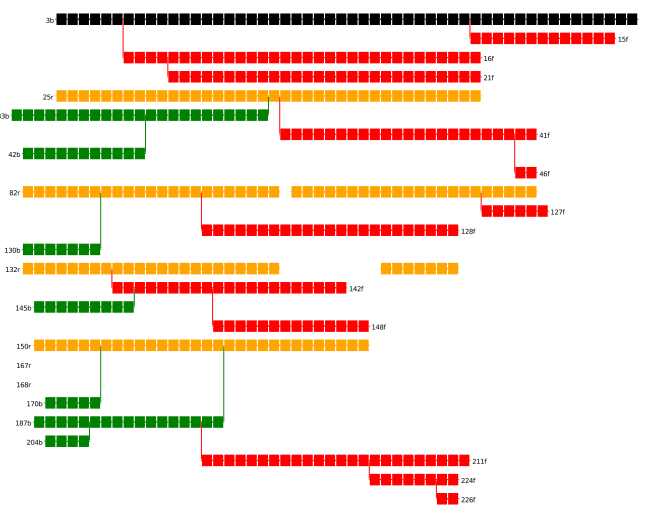

In [13]:
SVG(view.to_svg())

In [14]:
prev = first40[0].trajectory
decorrelated = [prev]
for s in first40:
    if not paths.Trajectory.is_correlated(s.trajectory, prev):
        decorrelated.append(s.trajectory)
        prev = s.trajectory
print "From these samples we have " + str(len(decorrelated)) + " decorrelated trajectories."

From these samples we have 4 decorrelated trajectories.


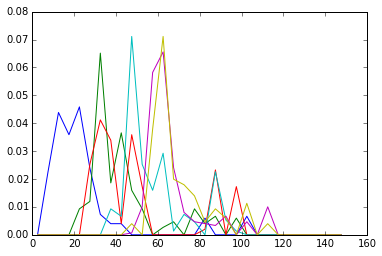

In [15]:
for ens in retis.ensembles:
    myhist = retis.histograms['pathlength'][ens]
    normalized = myhist.normalized()
    plt.plot(normalized.x, normalized)

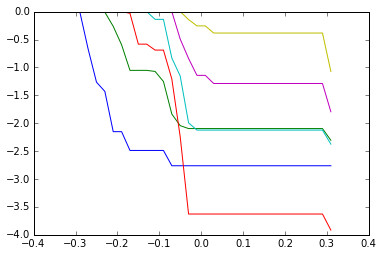

In [16]:
for ens in retis.ensembles:
    myhist = retis.histograms['max_lambda'][ens]
    reverse_cumulative = myhist.reverse_cumulative()
    plt.plot(reverse_cumulative.x, np.log(reverse_cumulative))


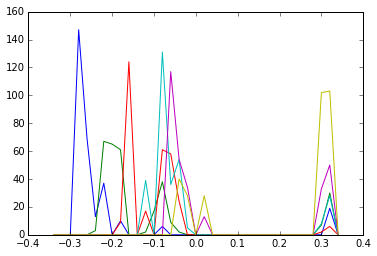

In [17]:
for ens in retis.ensembles:
    myhist = retis.histograms['max_lambda'][ens]()
    plt.plot(myhist.x, myhist)

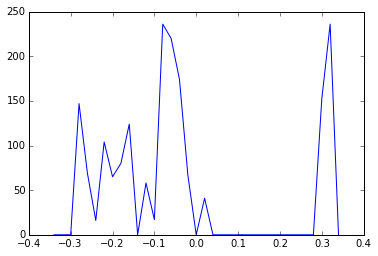

In [18]:
# TODO: add a histogram.sum_hist() function to add several histograms together
from operator import add
total_sampling = np.zeros(len(retis.histograms['max_lambda'][retis.ensembles[0]]()))
for ens in retis.ensembles:
    total_sampling = map(add, total_sampling, retis.histograms['max_lambda'][ens]())
plt.plot(myhist.x, total_sampling);

In [19]:
from toy_plot_helpers import ToyPlot
plot = ToyPlot()
plot.add_pes(storage.engines.load(0).pes)

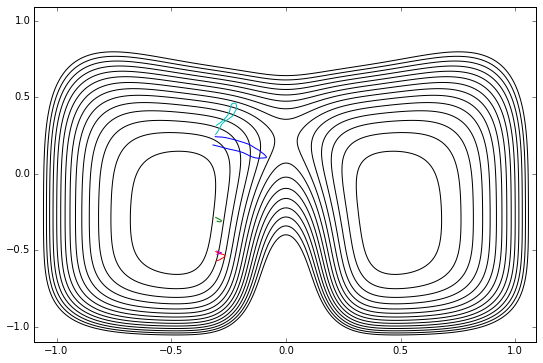

In [20]:
ens0_traj = [s.trajectory for s in storage.samples if s.ensemble == retis.ensembles[0]]
plt.contour(plot.X, plot.Y, plot._pes, levels=np.arange(0.0, 1.5, 0.1), colors='k')
for mytraj in ens0_traj[slice(None,None,15)]:
    plt.plot(mytraj.coordinates()[:,0,0], mytraj.coordinates()[:,0,1])

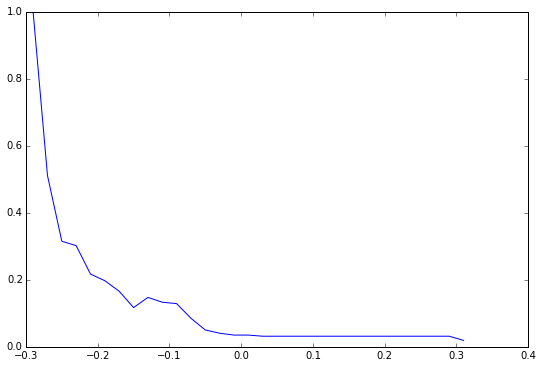

In [21]:
wham = retis.total_crossing_probability(method="wham")
plt.plot(wham.x, wham);

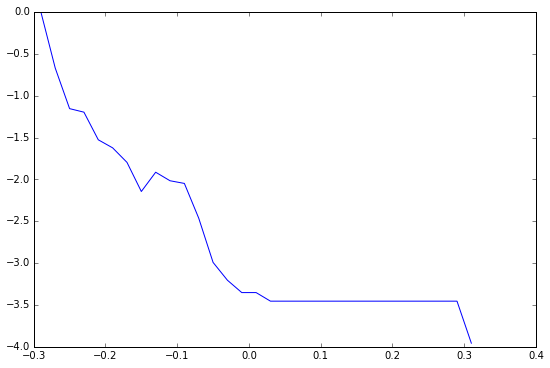

In [22]:
plt.plot(wham.x, np.log(wham));

In [23]:
%%time
#retis.rate(storage=storage)
# TODO: conditional_transition_probability, minus_flux, rate
retis.conditional_transition_probability(storage, retis.ensembles[-1])

CPU times: user 10.6 ms, sys: 3.22 ms, total: 13.8 ms
Wall time: 11.7 ms


0.6810631229235881

In [24]:
retis.minus_move_flux(storage)

0.012446657183499289

In [25]:
print retis._flux, retis.tcp(-0.05), retis.ctp[retis.ensembles[-1]]

0.0124466571835 0.0502006566276 0.681063122924


In [26]:
retis.rate(storage)

0.00042554891861495904

Note that, with insufficient data, the guess for the location of the outermost interface can be incorrect. If you specify the `outer_lambda`, you'll get a different answer.

In [27]:
retis.rate(storage, outer_lambda=-0.05)

0.00042554891861495915

In [28]:
print retis._flux * retis.tcp(-0.05) * retis.ctp[retis.ensembles[-1]]

0.000425548918615
